# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

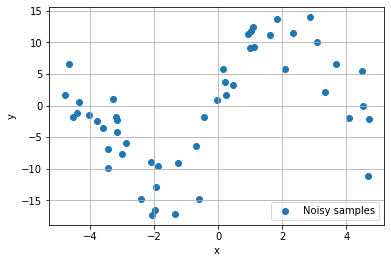

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

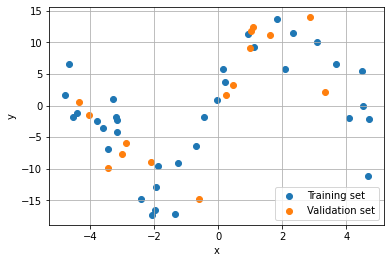

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

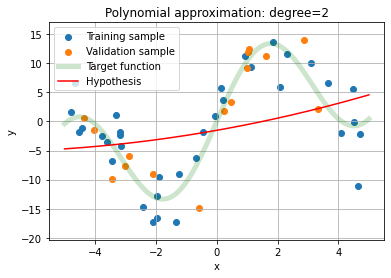

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

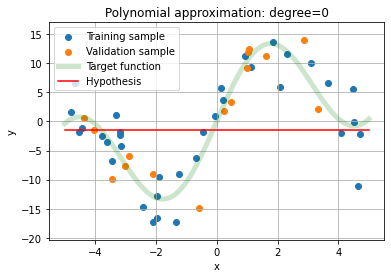

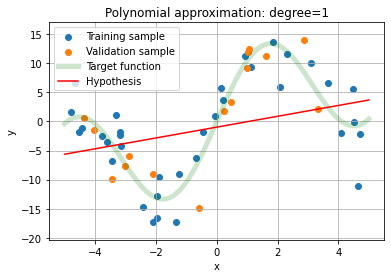

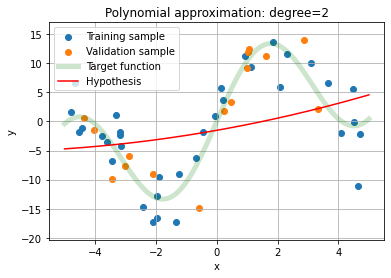

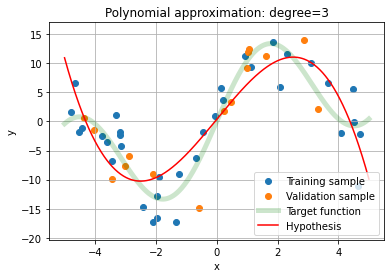

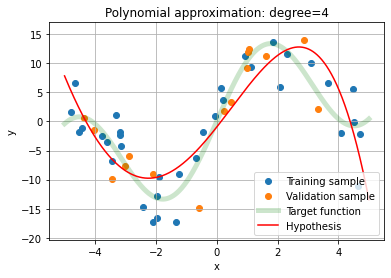

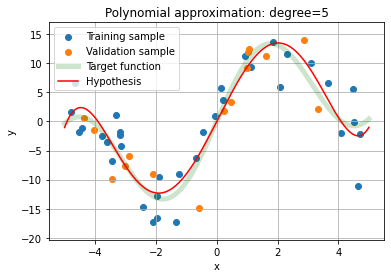

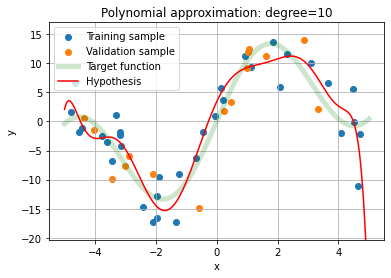

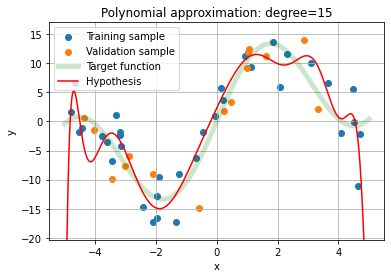

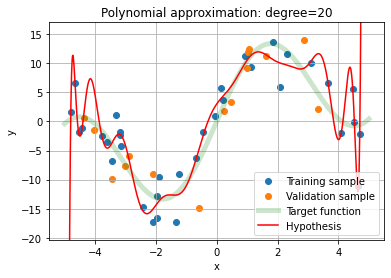

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

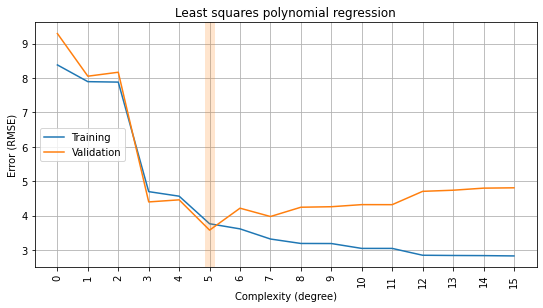

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

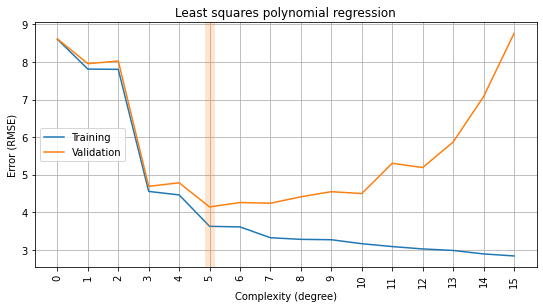

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

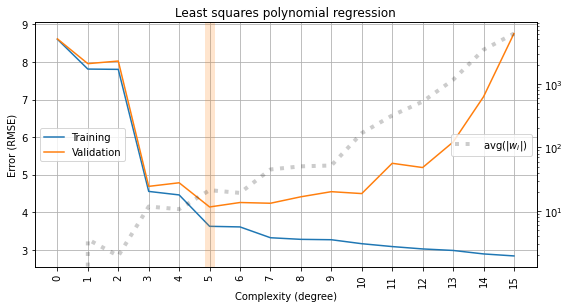

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

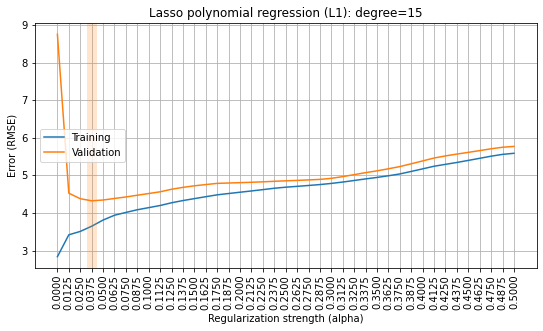

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

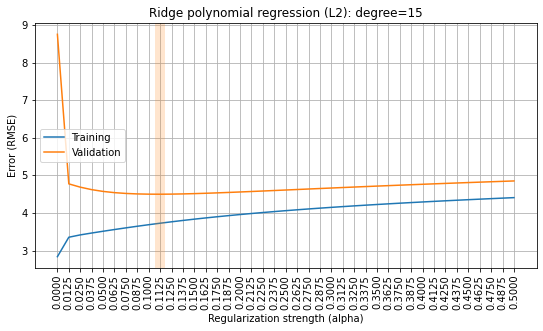

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR']) # занимает много места, уже читал, поэтому выключил

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

Построим графики признаков для визуального первичного анализа

Text(0.5, 1.0, 's6')

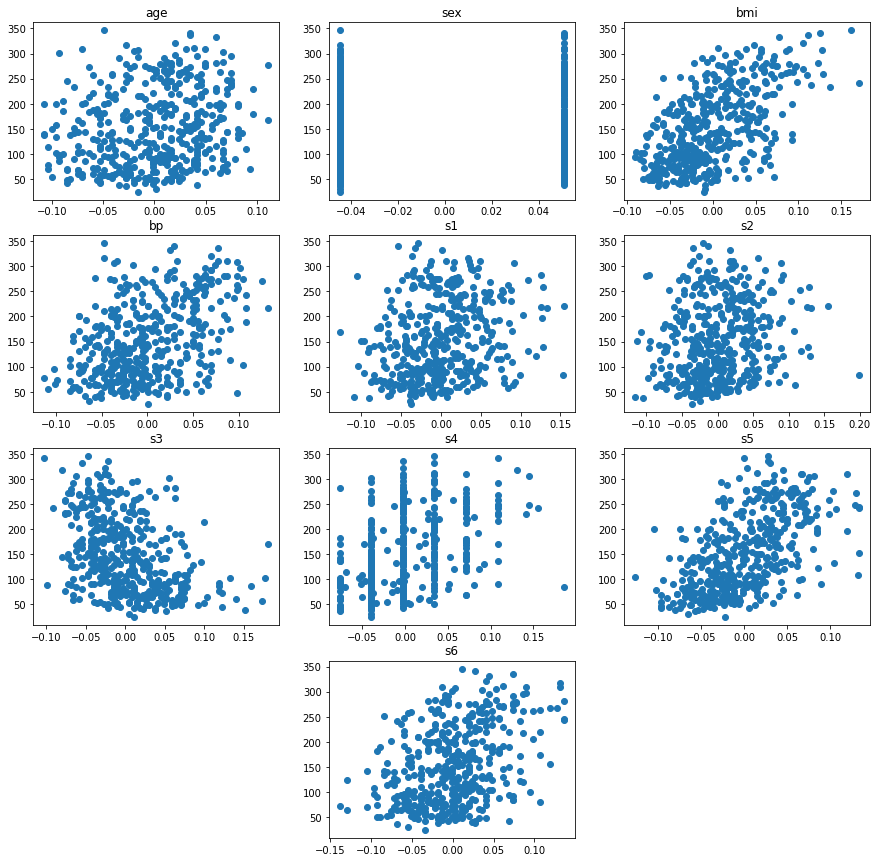

In [21]:
plt.figure(figsize=[15, 15])
plt.subplot(4, 3, 1)
plt.scatter(X_diabetes.age, y_diabetes);
plt.title('age')
plt.subplot(4, 3, 2)
plt.scatter(X_diabetes.sex, y_diabetes);
plt.title('sex')
plt.subplot(4, 3, 3)
plt.scatter(X_diabetes.bmi, y_diabetes);
plt.title('bmi')
plt.subplot(4, 3, 4)
plt.scatter(X_diabetes.bp, y_diabetes);
plt.title('bp')
plt.subplot(4, 3, 5)
plt.scatter(X_diabetes.s1, y_diabetes);
plt.title('s1')
plt.subplot(4, 3, 6)
plt.scatter(X_diabetes.s2, y_diabetes);
plt.title('s2')
plt.subplot(4, 3, 7)
plt.scatter(X_diabetes.s3, y_diabetes);
plt.title('s3')
plt.subplot(4, 3, 8)
plt.scatter(X_diabetes.s4, y_diabetes);
plt.title('s4')
plt.subplot(4, 3, 9)
plt.scatter(X_diabetes.s5, y_diabetes);
plt.title('s5')
plt.subplot(4, 3, 11)
plt.scatter(X_diabetes.s6, y_diabetes);
plt.title('s6')

На графиках видно, что явной четкой зависимости прогнозируемой переменной от признаков нет.
Большая часть графиков имеет положительную зависимость.
Большой разброс точек. Я бы сказал, что зависимость линейная, лучше всего подойдет полином 1-й степени

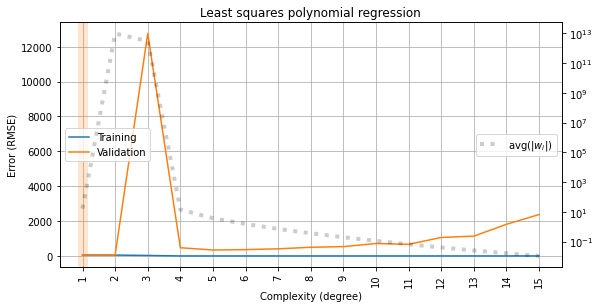

In [22]:
rmse_train, rmse_valid, coefs = [], [], []
degree_max = 16     # не включая это значение
for degree in DEGREES[1:degree_max]:
    results = cross_validate(make_model(degree),
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    coefs.append([model['reg'].coef_ for model in results['estimator']])

avg_coefs = [np.mean(np.abs(coef)) for coef in coefs]
plot_fitting_graph(DEGREES[1:degree_max], rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coefs, custom_label='avg(|$w_i$|)', title='Least squares polynomial regression')

Оптимальный degree: 1
Максимальный коэффициент (абс. значение): 912074771690876.8
Максимальный средний коэффициент (абс. значение): 6196.573209320214


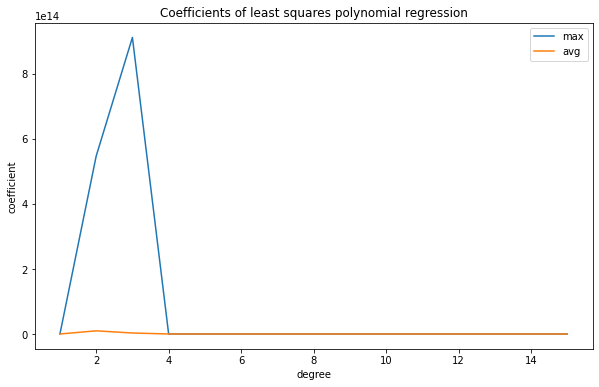

In [23]:
max_coefs = [np.max(coef) for coef in coefs]
max_coef = max(max_coefs)
plt.figure(figsize=(10, 6))
plt.plot(DEGREES[1:degree_max], max_coefs, label='max')
plt.plot(DEGREES[1:degree_max], avg_coefs, label='avg')
plt.title('Coefficients of least squares polynomial regression')
plt.xlabel('degree')
plt.ylabel('coefficient')
plt.legend()
print(f'Оптимальный degree: {DEGREES[1:degree_max][np.argmin(rmse_valid)]}')
print(f'Максимальный коэффициент (абс. значение): {max_coef}')
print(f'Максимальный средний коэффициент (абс. значение): {max(avg_coef)}')

Не смотря на то, что лучшая полиномиальная степень вычисляется как 1, мне кажется, что действительно лучшим значением будет 5.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

Подготавливаем массив X_transform, разделив массив X_train на два подмассива: один пройдет через процедуры полиномизации и скалинга, другой - только через скалинг

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)
split = 5   # граница раздела колонок для полиномизации и без нее
transformer = ColumnTransformer([
    ('to_polynomial', Pipeline(steps=[
        ('pol', PolynomialFeatures(degree, include_bias=False)),
        ('sca', StandardScaler())
    ]), X_train.columns[:split]),   # эти колонки пройдут через полиномизацию и скалинг
    ('only_scaler', Pipeline(steps=[
        ('sca', StandardScaler())
    ]), X_train.columns[split:]),   # остальные только через скалинг
], remainder='passthrough')
X_transform = transformer.fit_transform(X_train)
degree = 15
X_transform.shape

(309, 15508)

In [25]:
coefs_l1 = []
for alpha in ALPHAS:
    model = Lasso(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_transform, y_train)
    coefs_l1.append(model.coef_)

C:\Temp\ipykernel_10808\3395141477.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model = Lasso(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_transform, y_train)
e:\courses\4_overfitting_regularization\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
e:\courses\4_overfitting_regularization\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.714e+03, tolerance: 1.900e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mod

In [26]:
max_coefs_l1 = [np.max(coef) for coef in coefs_l1]
avg_coefs_l1 = [np.mean(np.abs(coef)) for coef in coefs_l1]
max_coef_l1 = max(max_coefs_l1)
print(f'Максимальный коэффициент (абс. значение): {max_coef_l1}')
print(f'Максимальный средний коэффициент (абс. значение): {max(avg_coefs_l1)}')

Максимальный коэффициент (абс. значение): 270.57317473623465
Максимальный средний коэффициент (абс. значение): 13.62818326944423


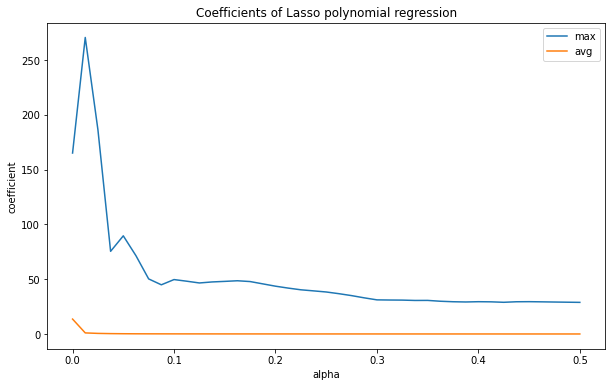

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(ALPHAS, max_coefs_l1, label='max')
plt.plot(ALPHAS, avg_coefs_l1, label='avg')
plt.title('Coefficients of Lasso polynomial regression')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.legend();

#### L2

In [28]:
coefs_l2 = []
for alpha in ALPHAS:
    model = Ridge(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_transform, y_train)
    coefs_l2.append(model.coef_)

e:\courses\4_overfitting_regularization\venv\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


In [29]:
max_coefs_l2 = [np.max(coef) for coef in coefs_l2]
avg_coefs_l2 = [np.mean(np.abs(coef)) for coef in coefs_l2]
max_coef_l2 = max(max_coefs_l2)
print(f'Максимальный коэффициент (абс. значение): {max_coef_l2}')
print(f'Максимальный средний коэффициент (абс. значение): {max(avg_coefs_l2)}')

Максимальный коэффициент (абс. значение): 214.62564316786165
Максимальный средний коэффициент (абс. значение): 13.73815339677615


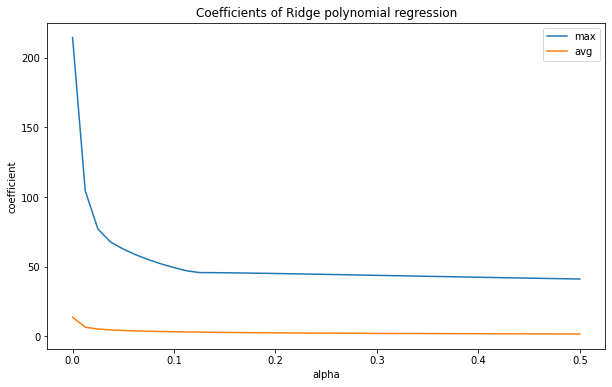

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(ALPHAS, max_coefs_l2, label='max')
plt.plot(ALPHAS, avg_coefs_l2, label='avg')
plt.title('Coefficients of Ridge polynomial regression')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.legend();

#### Summary

Вывод: графики выше наглядно отображают, что использование Lasso и Ridge качественно снижает размерность коэффициентов, позволяя моделям быть более простыми, а соответственно, и лучше предсказывать.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

Используем коэффициенты, полученные ранее в предыдущих упражнениях

1. Подсчитаем количество нулевых коэффициентов для стандартной модели

In [31]:
coef_count = 0
coef_nonzero_count = 0
for c in [np.array(coef) for coef in coefs]:
    fc = c.flatten()
    coef_count += fc.shape[0]
    coef_nonzero_count += np.count_nonzero(fc)
print(f'Общее количество коэффициентов: {coef_count}')
print(f'Количество ненулевых коэффициентов: {coef_nonzero_count}')
print(f'Итого количество нулевых коэффициентов: {coef_count - coef_nonzero_count}')

Общее количество коэффициентов: 38630720
Количество ненулевых коэффициентов: 38630720
Итого количество нулевых коэффициентов: 0


#### L1

2. Подсчитаем количество нулевых коэффициентов для Lasso

In [32]:
coef_count = 0
coef_nonzero_count = 0
for c in [np.array(coef) for coef in coefs_l1]:
    fc = c.flatten()
    coef_count += fc.shape[0]
    coef_nonzero_count += np.count_nonzero(fc)
print(f'Общее количество коэффициентов: {coef_count}')
print(f'Количество ненулевых коэффициентов: {coef_nonzero_count}')
print(f'Итого количество нулевых коэффициентов: {coef_count - coef_nonzero_count}')

Общее количество коэффициентов: 635828
Количество ненулевых коэффициентов: 22169
Итого количество нулевых коэффициентов: 613659


#### L2

3. Подсчитаем количество нулевых коэффициентов для Ridge

In [33]:
coef_count = 0
coef_nonzero_count = 0
for c in [np.array(coef) for coef in coefs_l2]:
    fc = c.flatten()
    coef_count += fc.shape[0]
    coef_nonzero_count += np.count_nonzero(fc)
print(f'Общее количество коэффициентов: {coef_count}')
print(f'Количество ненулевых коэффициентов: {coef_nonzero_count}')
print(f'Итого количество нулевых коэффициентов: {coef_count - coef_nonzero_count}')

Общее количество коэффициентов: 635828
Количество ненулевых коэффициентов: 635828
Итого количество нулевых коэффициентов: 0


#### Summary

Вывод: действительно, в процессе обучения модели Lasso некоторые коэффициенты обращаются в 0, что явно указывает на их незначимость для прогнозирования.
Стандартная модель или модель Ridge после обучения не содержат в себе нулевые коэффициенты.
Думаю, что в этом случае, при необходимости, можно установить порог (как выше 0, так и ниже), в пределах которого коэффициенты будут считаться незначимыми.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [34]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


Трансформированная через скалирование входная матрица

In [35]:
X_transform = StandardScaler().fit_transform(X_hw)

Некоторые примечания:
1. В это задаче я не использовал полиномизацию, поскольку не стоит задача предсказания.
2. По той же самой причине нет смысла делить массивы на train и test. Можно сделать вид, что наш входной массив - выборка из какой-нибудь генеральной совокупности.

#### L1

1. Посчитаем модель без скалирования

In [36]:
coefs_l1 = []
for alpha in ALPHAS:
    model = Lasso(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_hw, y)
    coefs_l1.append(model.coef_)

C:\Temp\ipykernel_10808\1741636885.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model = Lasso(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_hw, y)
e:\courses\4_overfitting_regularization\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
e:\courses\4_overfitting_regularization\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.471e+03, tolerance: 3.720e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/Ridg

In [37]:
max_coefs_l1 = [np.max(coef) for coef in coefs_l1]
avg_coefs_l1 = [np.mean(np.abs(coef)) for coef in coefs_l1]
max_coef_l1 = max(max_coefs_l1)
print(f'Максимальный коэффициент (абс. значение): {max_coef_l1}')
print(f'Максимальный средний коэффициент (абс. значение): {max(avg_coefs_l1)}')

Максимальный коэффициент (абс. значение): 124.0035880692565
Максимальный средний коэффициент (абс. значение): 41.33894610801665


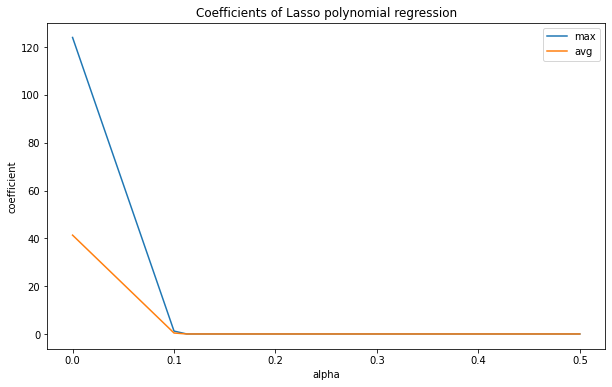

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(ALPHAS, max_coefs_l1, label='max')
plt.plot(ALPHAS, avg_coefs_l1, label='avg')
plt.title('Coefficients of Lasso polynomial regression')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.legend();

In [39]:
coef_count = 0
coef_nonzero_count = 0
for c in [np.array(coef) for coef in coefs_l1]:
    fc = c.flatten()
    coef_count += fc.shape[0]
    coef_nonzero_count += np.count_nonzero(fc)
print(f'Общее количество коэффициентов: {coef_count}')
print(f'Количество ненулевых коэффициентов: {coef_nonzero_count}')
print(f'Итого количество нулевых коэффициентов: {coef_count - coef_nonzero_count}')

Общее количество коэффициентов: 123
Количество ненулевых коэффициентов: 91
Итого количество нулевых коэффициентов: 32


2. А теперь со скалированием

In [40]:
coefs_l1 = []
for alpha in ALPHAS:
    model = Lasso(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_transform, y)
    coefs_l1.append(model.coef_)

C:\Temp\ipykernel_10808\276894176.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model = Lasso(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_transform, y)
e:\courses\4_overfitting_regularization\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
e:\courses\4_overfitting_regularization\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.471e+03, tolerance: 3.720e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridg

In [41]:
max_coefs_l1 = [np.max(coef) for coef in coefs_l1]
avg_coefs_l1 = [np.mean(np.abs(coef)) for coef in coefs_l1]
max_coef_l1 = max(max_coefs_l1)
print(f'Максимальный коэффициент (абс. значение): {max_coef_l1}')
print(f'Максимальный средний коэффициент (абс. значение): {max(avg_coefs_l1)}')

Максимальный коэффициент (абс. значение): 3.5462518653843085
Максимальный средний коэффициент (абс. значение): 1.8527638625708702


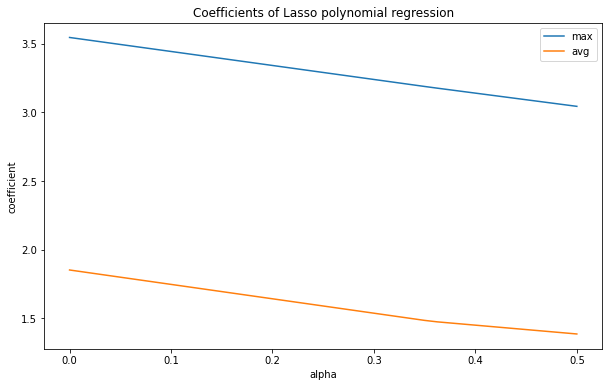

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(ALPHAS, max_coefs_l1, label='max')
plt.plot(ALPHAS, avg_coefs_l1, label='avg')
plt.title('Coefficients of Lasso polynomial regression')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.legend();

In [43]:
coef_count = 0
coef_nonzero_count = 0
for c in [np.array(coef) for coef in coefs_l1]:
    fc = c.flatten()
    coef_count += fc.shape[0]
    coef_nonzero_count += np.count_nonzero(fc)
print(f'Общее количество коэффициентов: {coef_count}')
print(f'Количество ненулевых коэффициентов: {coef_nonzero_count}')
print(f'Итого количество нулевых коэффициентов: {coef_count - coef_nonzero_count}')

Общее количество коэффициентов: 123
Количество ненулевых коэффициентов: 111
Итого количество нулевых коэффициентов: 12


#### L2

1. Посчитаем модель без скалирования

In [44]:
coefs_l2 = []
for alpha in ALPHAS:
    model = Ridge(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_hw, y)
    coefs_l2.append(model.coef_)

In [45]:
max_coefs_l2 = [np.max(coef) for coef in coefs_l2]
avg_coefs_l2 = [np.mean(np.abs(coef)) for coef in coefs_l2]
max_coef_l2 = max(max_coefs_l2)
print(f'Максимальный коэффициент (абс. значение): {max_coef_l2}')
print(f'Максимальный средний коэффициент (абс. значение): {max(avg_coefs_l2)}')

Максимальный коэффициент (абс. значение): 124.00358806925658
Максимальный средний коэффициент (абс. значение): 41.33894610801668


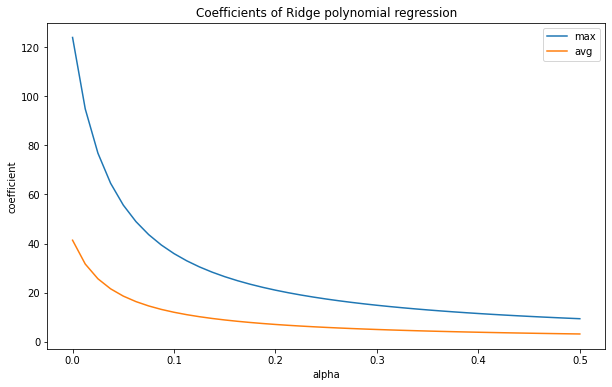

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(ALPHAS, max_coefs_l2, label='max')
plt.plot(ALPHAS, avg_coefs_l2, label='avg')
plt.title('Coefficients of Ridge polynomial regression')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.legend();

In [47]:
coef_count = 0
coef_nonzero_count = 0
for c in [np.array(coef) for coef in coefs_l2]:
    fc = c.flatten()
    coef_count += fc.shape[0]
    coef_nonzero_count += np.count_nonzero(fc)
print(f'Общее количество коэффициентов: {coef_count}')
print(f'Количество ненулевых коэффициентов: {coef_nonzero_count}')
print(f'Итого количество нулевых коэффициентов: {coef_count - coef_nonzero_count}')

Общее количество коэффициентов: 123
Количество ненулевых коэффициентов: 123
Итого количество нулевых коэффициентов: 0


2. А теперь со скалированием

In [48]:
coefs_l2 = []
for alpha in ALPHAS:
    model = Ridge(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_transform, y)
    coefs_l2.append(model.coef_)

In [49]:
max_coefs_l2 = [np.max(coef) for coef in coefs_l2]
avg_coefs_l2 = [np.mean(np.abs(coef)) for coef in coefs_l2]
max_coef_l2 = max(max_coefs_l2)
print(f'Максимальный коэффициент (абс. значение): {max_coef_l2}')
print(f'Максимальный средний коэффициент (абс. значение): {max(avg_coefs_l2)}')

Максимальный коэффициент (абс. значение): 3.5462518653843103
Максимальный средний коэффициент (абс. значение): 1.8527638625708704


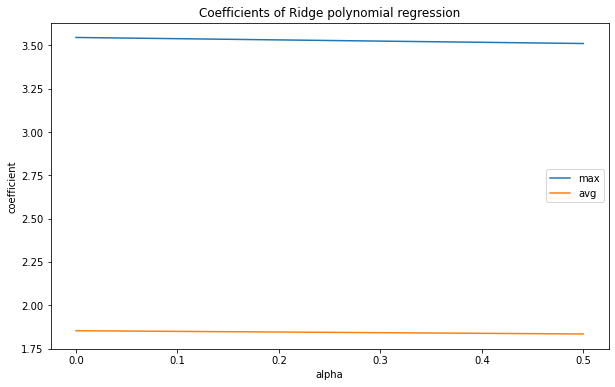

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(ALPHAS, max_coefs_l2, label='max')
plt.plot(ALPHAS, avg_coefs_l2, label='avg')
plt.title('Coefficients of Ridge polynomial regression')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.legend();

In [51]:
coef_count = 0
coef_nonzero_count = 0
for c in [np.array(coef) for coef in coefs_l2]:
    fc = c.flatten()
    coef_count += fc.shape[0]
    coef_nonzero_count += np.count_nonzero(fc)
print(f'Общее количество коэффициентов: {coef_count}')
print(f'Количество ненулевых коэффициентов: {coef_nonzero_count}')
print(f'Итого количество нулевых коэффициентов: {coef_count - coef_nonzero_count}')

Общее количество коэффициентов: 123
Количество ненулевых коэффициентов: 123
Итого количество нулевых коэффициентов: 0


#### Summary



Вывод: масштабирование признаков позволяет снизить и выровнять значения коэффициентов обучаемой линейной модели.
Помимо того, что это упрощает расчеты модели, это позволяет (в случае Lasso) более адекватно оценивать нулевые коэффициенты,
не позволяя полезной информации быть утерянной.
